In [108]:
# Imports
import datetime
import os
import random
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support # Function to evaluate: accuracy, precision, recall, f1-score
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import clone_model

In [109]:
%run Functions_Handler.ipynb

Notebook last run: 2024-06-24 13:16:20.564295


In [110]:
print(f"Notebook last run: {datetime.datetime.now()}")

Notebook last run: 2024-06-24 13:16:20.591912


In [111]:
#Start by using the 20k dataset
data_dir = "C:/Users/user/Desktop/pubmed-rct-master/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [112]:
train_df, val_df, test_df, train_sentences, val_sentences, test_sentences = load_and_preprocess_pubmed_data(data_dir)

In [113]:
#One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
#Extract labels ("target" columns) and encode them into integers
label_encoder = LabelEncoder()

In [114]:
train_labels_one_hot, val_labels_one_hot, test_labels_one_hot = perform_one_hot_encoding(
    one_hot_encoder, train_df, val_df, test_df, target_column="target")

C:\Users\user\anaconda2\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [115]:
train_labels_encoded, val_labels_encoded, test_labels_encoded = perform_label_encoding(
    label_encoder, train_df, val_df, test_df, target_column="target")

In [116]:
train_dataset = create_tf_datasets(train_sentences, train_labels_one_hot)
valid_dataset = create_tf_datasets(val_sentences, val_labels_one_hot)
test_dataset = create_tf_datasets(test_sentences, test_labels_one_hot)

In [117]:
#Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## MODEL 0 BASELINE

In [118]:
#Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# it the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [119]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [120]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [121]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [122]:
# How long is each sentence on average? Preparing our data for deep sequence models
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

In [123]:
#How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

In [124]:
#How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [125]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,  # number of words in vocabulary
                                    output_sequence_length=output_seq_len)  # desired output length of vectorized sequences

#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [126]:
#How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [127]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

In [128]:
# Split sequence-level data splits into character-level data splits
train_chars = split_chars_in_sentences(train_sentences)
val_chars = split_chars_in_sentences(val_sentences)
test_chars = split_chars_in_sentences(test_sentences)
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [129]:
char_lens = [len(sentence) for sentence in train_sentences]
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [130]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [131]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

## MODEL 1 hybrid

In [132]:
# Define a custom layer for Universal Sentence Encoder (USE)
class USELayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

    def call(self, inputs):
        return self.use(tf.squeeze(tf.cast(inputs, tf.string)))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 512)  # Output shape of USE layer

# Initialize the USE layer
use_layer = USELayer()

In [133]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = use_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_1 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_1_token_and_char_embeddings")

In [134]:
# Get summary of token and character model
model_1.summary()

Model: "model_1_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_input (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ char_vectorizer               │ (None, 290)               │               0 │ char_input[0][0]           │
│ (TextVectorization)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ use_layer_3 (USELayer)        │ (None, 512)               │               0 │ token_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ char_embed (Embedding)        │ (None, 290, 25)           │           1,750 │ char_vectorizer[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 128)               │          65,664 │ use_layer_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_6               │ (None, 50)                │          10,200 │ char_embed[0][0]           │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_char_hybrid             │ (None, 178)               │               0 │ dense_22[0][0],            │
│ (Concatenate)                 │                           │                 │ bidirectional_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 178)               │               0 │ token_char_hybrid[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 200)               │          35,800 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 200)               │               0 │ dense_23[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_24 (Dense)              │ (None, 5)                 │           1,005 │ dropout_9[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 114,419 (446.95 KB)

 Trainable params: 114,419 (446.95 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
# Compile token char model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [136]:
train_char_token_dataset = create_char_token_datasets(train_sentences, train_chars, train_labels_one_hot)
val_char_token_dataset = create_char_token_datasets(val_sentences, val_chars, val_labels_one_hot)

In [137]:
# Fit the model on tokens and chars
model_1_history = model_1.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.5271 - loss: 1.1506 - val_accuracy: 0.6905 - val_loss: 0.7927
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.6914 - loss: 0.8062 - val_accuracy: 0.7227 - val_loss: 0.7206
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7086 - loss: 0.7683 - val_accuracy: 0.7390 - val_loss: 0.6904


In [138]:
# Evaluate on the whole validation dataset
model_1.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.7318 - loss: 0.6981


[0.698871910572052, 0.7325897216796875]

In [139]:
# Make predictions using the token-character model hybrid
model_1_pred_probs = model_1.predict(val_char_token_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step


array([[3.9381304e-01, 4.1208518e-01, 3.3616463e-03, 1.8252347e-01,
        8.2166102e-03],
       [3.0384532e-01, 5.2551019e-01, 2.3692765e-03, 1.6594131e-01,
        2.3338536e-03],
       [2.5413585e-01, 9.2481852e-02, 3.8048033e-02, 5.8947849e-01,
        2.5855750e-02],
       ...,
       [4.4290008e-04, 6.7616752e-03, 5.4734562e-02, 2.4710828e-04,
        9.3781364e-01],
       [9.2809368e-03, 6.1968189e-02, 2.4239701e-01, 6.3117105e-03,
        6.8004221e-01],
       [2.4641715e-01, 4.8393205e-01, 2.1771666e-01, 2.0723589e-02,
        3.1210501e-02]], dtype=float32)

In [140]:
# Turn prediction probabilities into prediction classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [141]:
# Get results of token-char-hybrid model
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 73.25896994571693,
 'precision': 0.732183479369597,
 'recall': 0.7325896994571693,
 'f1': 0.7296786327646396}

## Model 2: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings 

In [142]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [143]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid embedding model

In [144]:
model_2 = create_model()
# Get a summary of our token, char and positional embedding model
model_2.summary()

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_inputs (InputLayer)     │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ char_vectorizer               │ (None, 290)               │               0 │ char_inputs[0][0]          │
│ (TextVectorization)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ use_layer_3 (USELayer)        │ (None, 512)               │               0 │ token_inputs[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ char_embed (Embedding)        │ (None, 290, 25)           │           1,750 │ char_vectorizer[1][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_25 (Dense)              │ (None, 128)               │          65,664 │ use_layer_3[1][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_7               │ (None, 64)                │          14,848 │ char_embed[1][0]           │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_char_hybrid_embedding   │ (None, 192)               │               0 │ dense_25[0][0],            │
│ (Concatenate)                 │                           │                 │ bidirectional_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ line_number_input             │ (None, 15)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_lines_input             │ (None, 20)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_28 (Dense)              │ (None, 256)               │          49,408 │ token_char_hybrid_embeddi… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_26 (Dense)              │ (None, 32)                │             512 │ line_number_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_27 (Dense)              │ (None, 32)                │             672 │ total_lines_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 256)               │               0 │ dense_28[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_char_positional_embedd… │ (None, 320)               │               

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

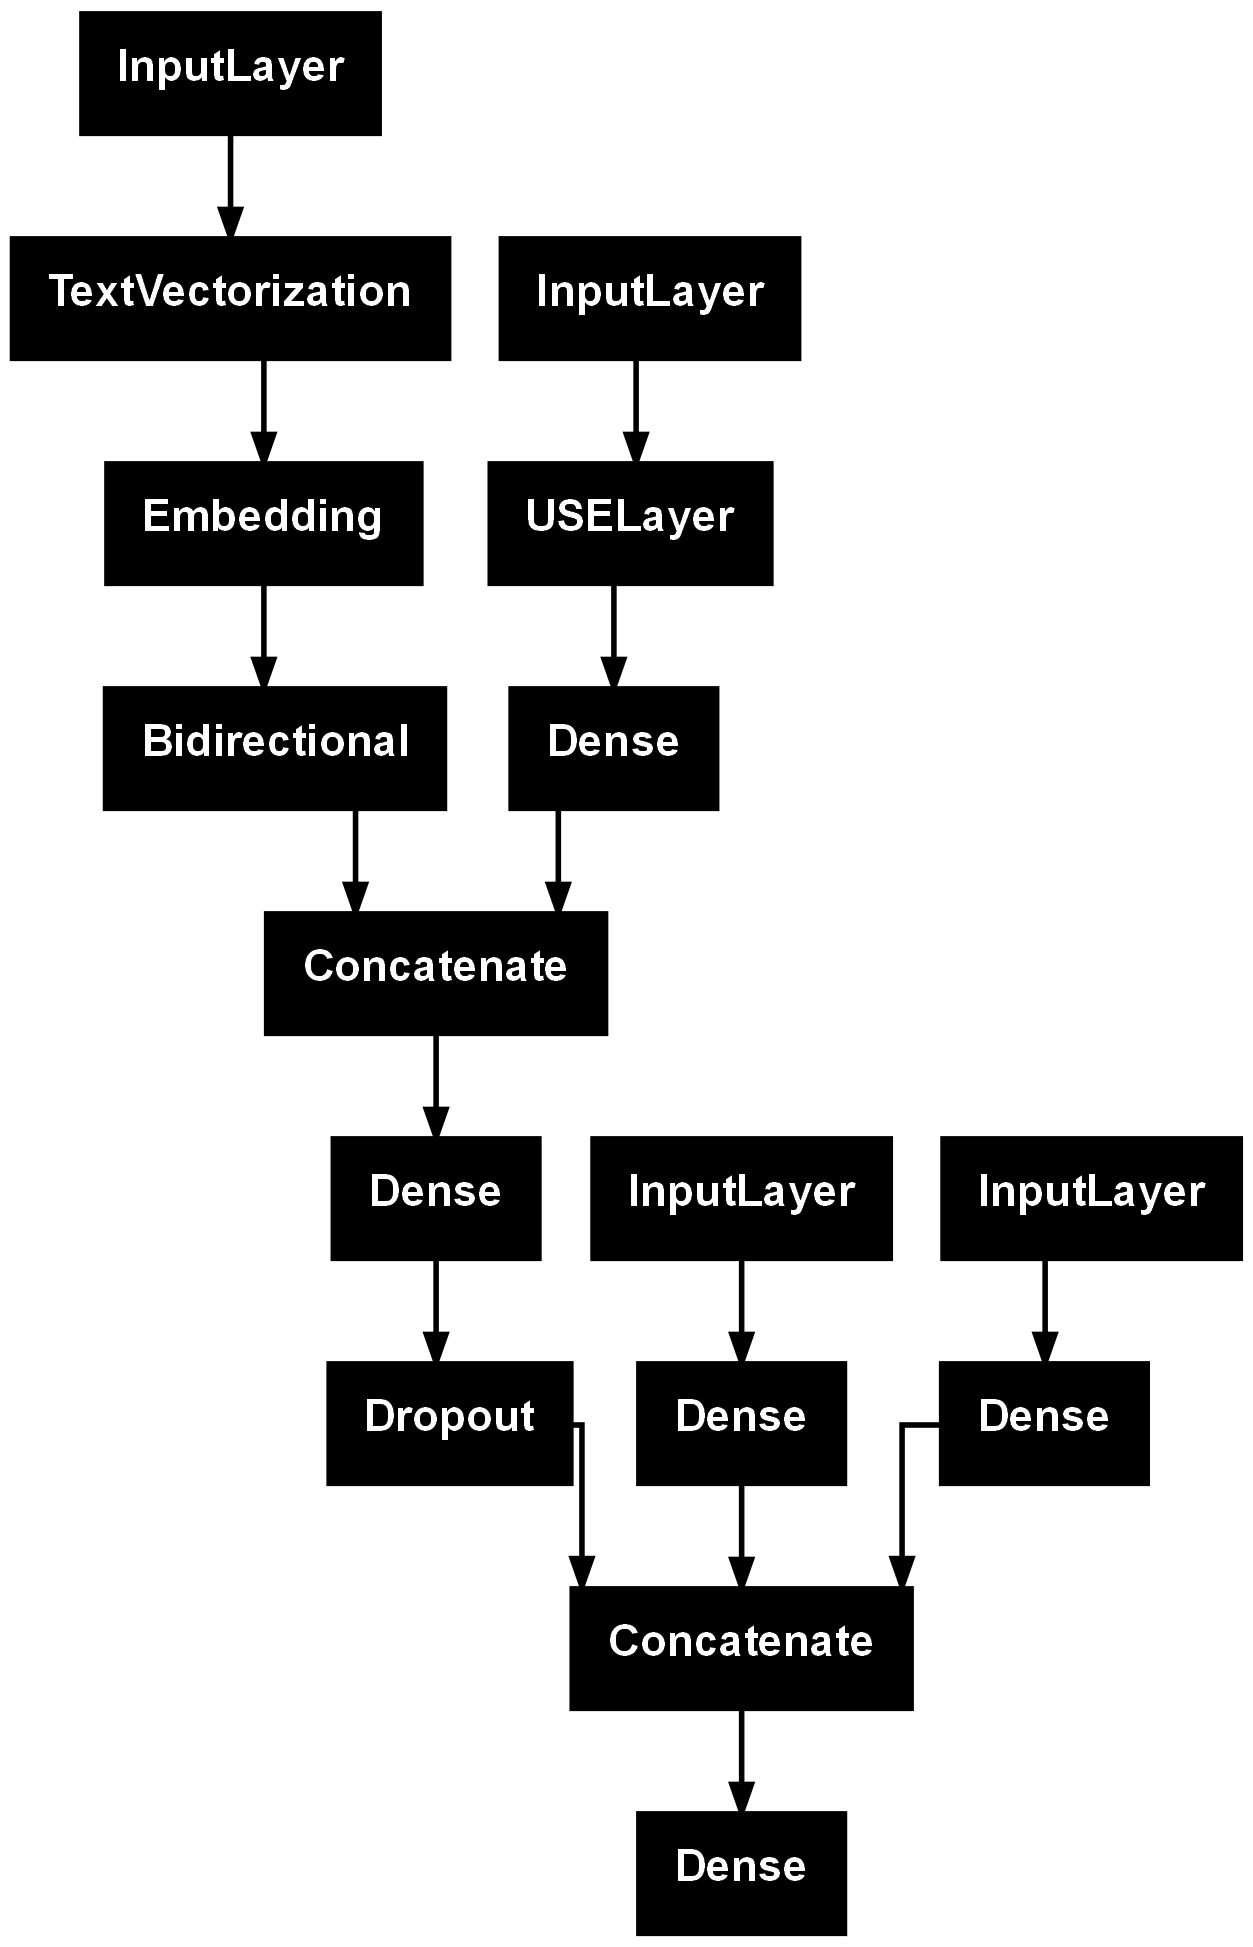

In [145]:
# Plot the token, char, positional embedding model
plot_model(model_2)

In [146]:
# Compile token, char, positional embedding model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [147]:
# Creates a TensorFlow dataset by combining one-hot encoded line numbers, total lines, sentences, and characters
train_pos_char_token_dataset = create_position_char_token_datasets(train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars, train_labels_one_hot)
val_pos_char_token_dataset = create_position_char_token_datasets(val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars, val_labels_one_hot)

In [148]:
# Fit the token, char and positional embedding model
history_model_2 = model_2.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.6266 - loss: 1.2281 - val_accuracy: 0.8022 - val_loss: 0.9893
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8116 - loss: 0.9719 - val_accuracy: 0.8201 - val_loss: 0.9459
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8192 - loss: 0.9561 - val_accuracy: 0.8258 - val_loss: 0.9380


In [149]:
# Make predictions with token-char-positional hybrid model
model_2_pred_probs = model_2.predict(val_pos_char_token_dataset, verbose=1)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step


array([[0.5137447 , 0.09867244, 0.0091917 , 0.36338586, 0.01500531],
       [0.53632146, 0.09888549, 0.04315115, 0.31144387, 0.01019807],
       [0.3375034 , 0.09457131, 0.13615312, 0.3680479 , 0.0637243 ],
       ...,
       [0.03716464, 0.09670827, 0.04514024, 0.0324568 , 0.78853005],
       [0.02751304, 0.28242454, 0.08378637, 0.02821216, 0.57806385],
       [0.28667897, 0.4823199 , 0.11082359, 0.04900361, 0.07117392]],
      dtype=float32)

In [150]:
# Turn prediction probabilities into prediction classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [151]:
# Calculate results of token-char-positional hybrid model
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 83.15900966503375,
 'precision': 0.830866863615886,
 'recall': 0.8315900966503376,
 'f1': 0.8302043621226725}

## Model 3: Train `model_2` on all of the data in the training dataset for as many epochs until it stops improving with callbacks

In [152]:
model_3 = create_model()
# Check the summary of model_3 to verify it's been cloned correctly
model_3.summary()

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_inputs (InputLayer)     │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ char_vectorizer               │ (None, 290)               │               0 │ char_inputs[0][0]          │
│ (TextVectorization)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ use_layer_3 (USELayer)        │ (None, 512)               │               0 │ token_inputs[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ char_embed (Embedding)        │ (None, 290, 25)           │           1,750 │ char_vectorizer[2][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_29 (Dense)              │ (None, 128)               │          65,664 │ use_layer_3[2][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_8               │ (None, 64)                │          14,848 │ char_embed[2][0]           │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_char_hybrid_embedding   │ (None, 192)               │               0 │ dense_29[0][0],            │
│ (Concatenate)                 │                           │                 │ bidirectional_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ line_number_input             │ (None, 15)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_lines_input             │ (None, 20)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_32 (Dense)              │ (None, 256)               │          49,408 │ token_char_hybrid_embeddi… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_30 (Dense)              │ (None, 32)                │             512 │ line_number_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_31 (Dense)              │ (None, 32)                │             672 │ total_lines_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 256)               │               0 │ dense_32[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_char_positional_embedd… │ (None, 320)               │               

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
# Creating the callbacks 
check_filepath = 'best_weights/checkpoint.weights.h5'

#Callback to save the Keras model or model weights at some frequency.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath , 
                                                               save_weights_only = True , 
                                                               save_best_only = True  , 
                                                               save_freq = 'epoch' , 
                                                               monitor = 'val_loss')

#Stop training when a monitored metric has stopped improving.
early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' , 
                                                   patience = 3, min_delta = 0.5 , verbose = 1)


#Reduce learning rate when a metric has stopped improving.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [154]:
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) ,
                    optimizer = tf.keras.optimizers.Adam() ,
                    metrics = ['accuracy'])

history = model_3.fit(train_pos_char_token_dataset , 
                      epochs = 50 , 
                      validation_data = val_pos_char_token_dataset  , 
                      callbacks = [early_stopping , model_checkpoint_callback , 
                                   reduce_lr])

Epoch 1/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 447s 79ms/step - accuracy: 0.7859 - loss: 1.0078 - val_accuracy: 0.8465 - val_loss: 0.9102 - learning_rate: 0.0010
Epoch 2/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 430s 76ms/step - accuracy: 0.8511 - loss: 0.9146 - val_accuracy: 0.8532 - val_loss: 0.8997 - learning_rate: 0.0010
Epoch 3/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 408s 72ms/step - accuracy: 0.8606 - loss: 0.9013 - val_accuracy: 0.8510 - val_loss: 0.8983 - learning_rate: 0.0010
Epoch 4/50
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 412s 73ms/step - accuracy: 0.8677 - loss: 0.8922 - val_accuracy: 0.8510 - val_loss: 0.8993 - learning_rate: 0.0010
Epoch 4: early stopping


In [155]:
# Make predictions with token-char-positional hybrid model
model_3_pred_probs = model_3.predict(val_pos_char_token_dataset, verbose=1)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step


array([[0.5898764 , 0.08672267, 0.02250056, 0.2710599 , 0.02984044],
       [0.61249894, 0.12700091, 0.02888033, 0.21725167, 0.01436813],
       [0.36983725, 0.07510218, 0.03795734, 0.47170508, 0.04539814],
       ...,
       [0.0236883 , 0.07575001, 0.01503069, 0.02788143, 0.8576495 ],
       [0.01917836, 0.2683179 , 0.05958125, 0.02485156, 0.6280709 ],
       [0.05660625, 0.8788498 , 0.02733416, 0.0253669 , 0.01184287]],
      dtype=float32)

In [156]:
# Turn prediction probabilities into prediction classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [157]:
# Calculate results of token-char-positional hybrid model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 85.09532636038661,
 'precision': 0.8529696204456707,
 'recall': 0.850953263603866,
 'f1': 0.8479846805099942}

In [158]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "hybrid_char_token_embed": model_1_results,
                                  "tribrid_pos_char_token_embed": model_2_results,
                                   "callbacks_model": model_3_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
hybrid_char_token_embed,73.258970,0.732183,0.732590,0.729679
tribrid_pos_char_token_embed,83.159010,0.830867,0.831590,0.830204
callbacks_model,85.095326,0.852970,0.850953,0.847985


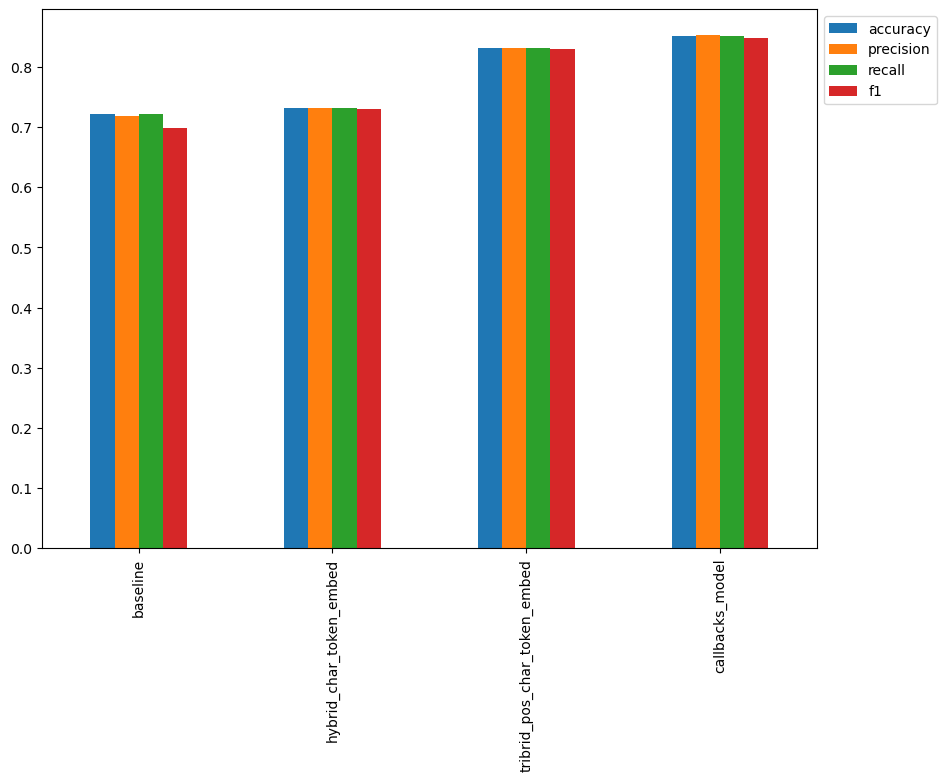

In [159]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));